<a href="https://colab.research.google.com/github/BruunoRangel/Planejamento-Ultrassom-/blob/main/nnU_Net_Dataaugmentation_Pocus_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet50
from torchvision.models import resnet50
plt.ion()   # interactive mode
from PIL import Image
import random
# connect drive
from google.colab import drive
from torch.utils.data import ConcatDataset
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
!ls 'gdrive/MyDrive/Modelo_01/data/data_pocus/'

test  train  val


In [46]:
# dataset com shape das imagens variados 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}
data_dir = 'gdrive/MyDrive/Modelo_01/data/data_pocus/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}



Número de imagens para cada classe: ('pneumonia ', 314)
Número de imagens para cada classe: ('covid', 267)
Número de imagens para cada classe: ('saudável', 790)


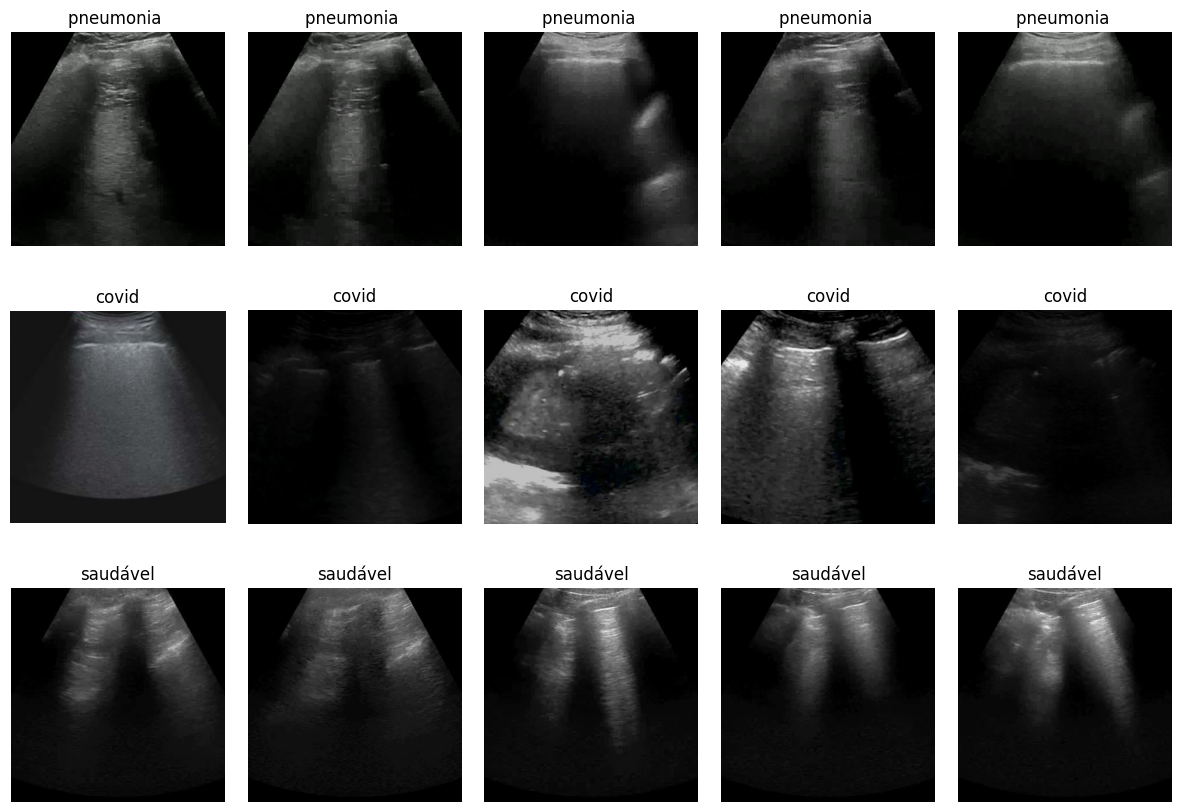

In [47]:
path = 'gdrive/MyDrive/Modelo_01/data/data_pocus/train/'

subdirs = os.listdir(path)

fig, axs = plt.subplots(len(subdirs), 5, figsize=(15, 10))
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(path, subdir)
    imgs = os.listdir(subdir_path)[:5]  # selecione os 5 primeiros arquivos de imagem
    print('Número de imagens para cada classe: ' f"{subdir,len(os.listdir(subdir_path))}")
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(subdir_path, img_name)
        img = plt.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{subdir}")
        axs[i, j].axis("off")

# Ajusta o espaçamento entre os subplots
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


Média da intensidade de pixels para pneumonia : 33.81
Média da intensidade de pixels para covid: 52.93
Média da intensidade de pixels para saudável: 31.61


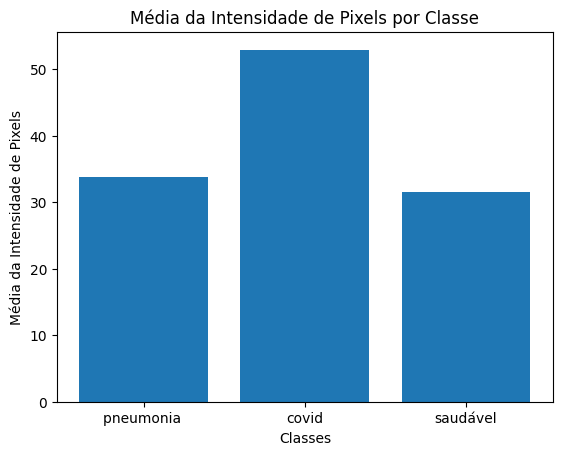

In [48]:
path = 'gdrive/MyDrive/Modelo_01/data/data_pocus/train/'
subdirs = os.listdir(path)
avg_pixel_vals = []

for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(path, subdir)
    imgs = os.listdir(subdir_path)
    avg_subdir_pixel_val = 0
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(subdir_path, img_name)
        img = plt.imread(img_path)
        avg_subdir_pixel_val += np.mean(img) / len(imgs)
    avg_pixel_vals.append(avg_subdir_pixel_val)
    print(f"Média da intensidade de pixels para {subdir}: {avg_subdir_pixel_val:.2f}")

plt.bar(subdirs, avg_pixel_vals)
plt.title('Média da Intensidade de Pixels por Classe')
plt.xlabel('Classes')
plt.ylabel('Média da Intensidade de Pixels')
plt.show()

In [49]:
import os
import cv2
import numpy as np

# Directory containing the original images
input_dir = 'gdrive/MyDrive/Modelo_01/data/data_pocus/train/'

# Directory to save the augmented images
output_dir = 'gdrive/MyDrive/Modelo_01/data/data_pocus02/'


# Define the brightness range
brightness_range = (0.7, 1.3)

# Define the number of augmented samples for each class
num_augmentations = {
    'saudável': 2,
    'pneumonia ': 3,
    'covid': 5
}

# Function to apply brightness augmentation
def apply_brightness(image, brightness_factor):
    brightened_image = image * brightness_factor
    return brightened_image

# Iterate over the classes
for class_name, num_augment in num_augmentations.items():
    class_dir = os.path.join(input_dir, class_name)
    images = os.listdir(class_dir)

    # Iterate over the images in the class
    for image_name in images:
        # Load the image
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)

        # Apply brightness augmentation
        for i in range(num_augment):
            # Generate a random brightness factor within the specified range
            brightness_factor = np.random.uniform(*brightness_range)

            # Apply brightness augmentation
            brightened_image = apply_brightness(image, brightness_factor)

            # Save the augmented image to the output directory
            output_class_dir = os.path.join(output_dir, class_name)
            os.makedirs(output_class_dir, exist_ok=True)
            augmented_image_name = f"{image_name.split('.')[0]}_augmented_{i+1}.{image_name.split('.')[-1]}"
            output_path = os.path.join(output_class_dir, augmented_image_name)
            cv2.imwrite(output_path, brightened_image)


In [50]:
import shutil


output_dir_expanded = 'gdrive/MyDrive/Modelo_01/data/pocus_augmentation/'
os.makedirs(output_dir_expanded, exist_ok=True)

# Copiar as imagens originais para o diretório expandido
for class_name in ['saudável', 'pneumonia ', 'covid']:
    class_dir_original = os.path.join(input_dir, class_name)
    class_dir_expanded = os.path.join(output_dir_expanded, class_name)
    os.makedirs(class_dir_expanded, exist_ok=True)

    images = os.listdir(class_dir_original)
    for image_name in images:
        image_path_original = os.path.join(class_dir_original, image_name)
        image_path_expanded = os.path.join(class_dir_expanded, image_name)
        shutil.copyfile(image_path_original, image_path_expanded)

# Copiar as imagens aumentadas para o diretório expandido
for class_name in ['saudável', 'pneumonia ', 'covid']:
    class_dir_expanded = os.path.join(output_dir_expanded, class_name)
    class_dir_augmented = os.path.join(output_dir, class_name)

    images_augmented = os.listdir(class_dir_augmented)
    for image_name_augmented in images_augmented:
        image_path_augmented = os.path.join(class_dir_augmented, image_name_augmented)
        image_path_expanded = os.path.join(class_dir_expanded, image_name_augmented)
        shutil.copyfile(image_path_augmented, image_path_expanded)



In [52]:
data_dir1 = 'gdrive/MyDrive/Modelo_01/data/pocus_augmentation/'
print(len(image_datasets['train']))

image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir1, 'train'), data_transforms['train'])

print(len(image_datasets['train']))

1371
1657


In [53]:
#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [54]:
#Tamanhos darasets 
print("Quantidade de imagens dataset de treino:",len(image_datasets['train']))
print("Quantidade de imagens dataset de validação:",len(image_datasets['val']))
print("Quantidade de imagens dataset de teste:",len(image_datasets['val']))

Quantidade de imagens dataset de treino: 1657
Quantidade de imagens dataset de validação: 469
Quantidade de imagens dataset de teste: 469


In [55]:
#Quantidades de batchs em cada dataloader 
print("Quantidade de Batchs dataloader de treino:",len(dataloaders['train']))
print("Quantidade de Batchs dataloader de validação:",len(dataloaders['val']))
print("Quantidade de Batchs dataloader de teste:",len(dataloaders['test']))

Quantidade de Batchs dataloader de treino: 70
Quantidade de Batchs dataloader de validação: 20
Quantidade de Batchs dataloader de teste: 15


In [56]:
# Check which GPU we are using
!nvidia-smi

Fri May 19 00:00:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:
inputs, classes = next(iter(dataloaders['train']))

Batch of training data


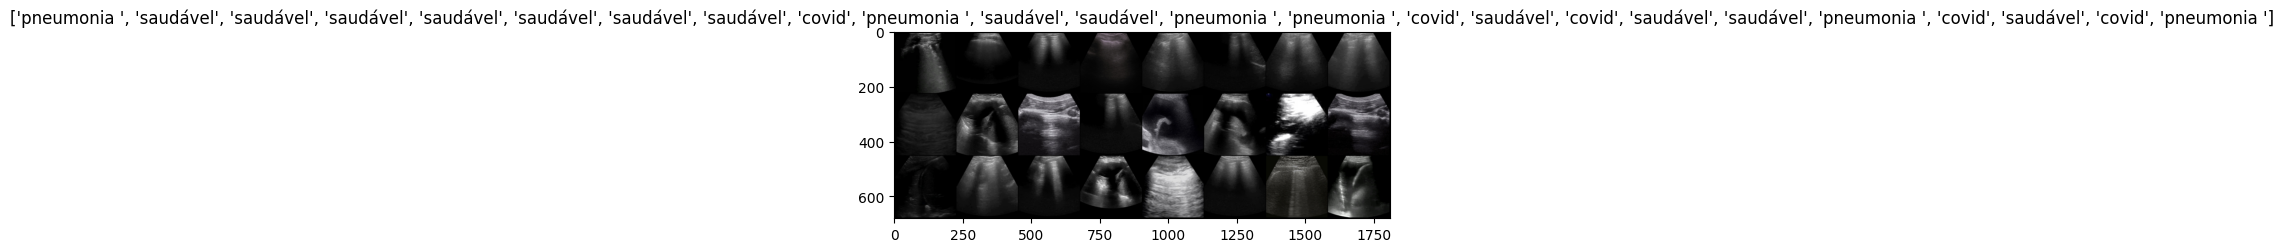

min =  0.0
median =  0.07058824
mean =  0.14689597
max =  1.0
Batch of validation data


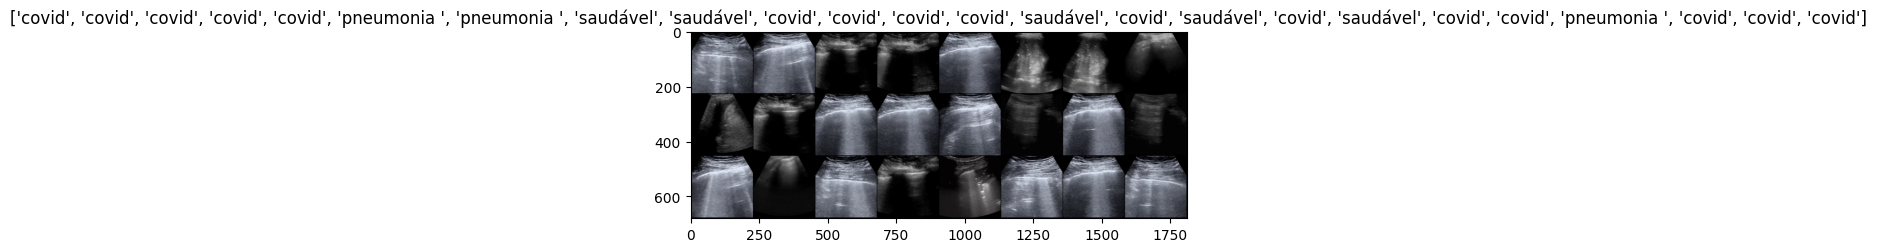

min =  0.0
median =  0.22352941
mean =  0.2547373
max =  0.99215686
Batch of test data


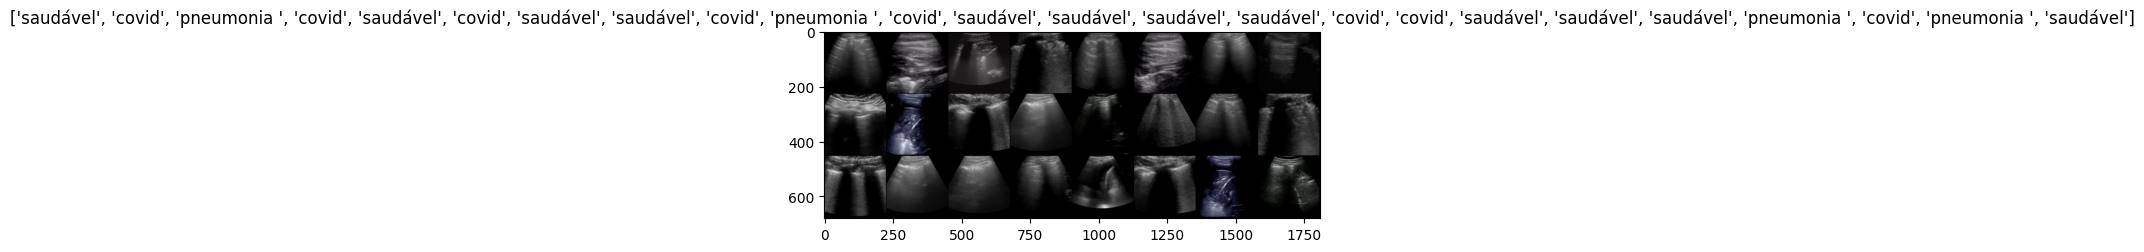

min =  0.0
median =  0.078431375
mean =  0.13437451
max =  1.0


In [58]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

In [59]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epochs.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                   
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [60]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=99df2748056ca304ca2728a4ae18e18102b7996f38925ad8daa4855e8da35a84
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [61]:
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device) #send the model to GPU if it is available or CPU otherwise

criterion = nn.CrossEntropyLoss()

optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 15.2MB/s]


Loaded pretrained weights for efficientnet-b0


In [62]:
# print(model) # show CNN architecture

summary(model, (3, 224, 224)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [63]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []
epochs = []

model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                        num_epochs=100)

Epoch 0/99
----------
train Loss: 7.0494 Acc: 0.0054
val Loss: 7.1987 Acc: 0.0000

Epoch 1/99
----------
train Loss: 6.3810 Acc: 0.0386
val Loss: 7.3743 Acc: 0.0000

Epoch 2/99
----------
train Loss: 5.6548 Acc: 0.1442
val Loss: 7.6017 Acc: 0.0000

Epoch 3/99
----------
train Loss: 4.9479 Acc: 0.2710
val Loss: 7.5018 Acc: 0.0000

Epoch 4/99
----------
train Loss: 4.3944 Acc: 0.3470
val Loss: 7.2392 Acc: 0.0000

Epoch 5/99
----------
train Loss: 3.8974 Acc: 0.4188
val Loss: 6.9018 Acc: 0.0000

Epoch 6/99
----------
train Loss: 3.4900 Acc: 0.4955
val Loss: 6.2586 Acc: 0.0021

Epoch 7/99
----------
train Loss: 3.1569 Acc: 0.5552
val Loss: 5.5347 Acc: 0.0554

Epoch 8/99
----------
train Loss: 2.8130 Acc: 0.6156
val Loss: 4.8225 Acc: 0.1578

Epoch 9/99
----------
train Loss: 2.4592 Acc: 0.6904
val Loss: 4.1888 Acc: 0.3198

Epoch 10/99
----------
train Loss: 2.1569 Acc: 0.7326
val Loss: 3.5300 Acc: 0.4819

Epoch 11/99
----------
train Loss: 1.8924 Acc: 0.7773
val Loss: 3.0493 Acc: 0.6290

Ep

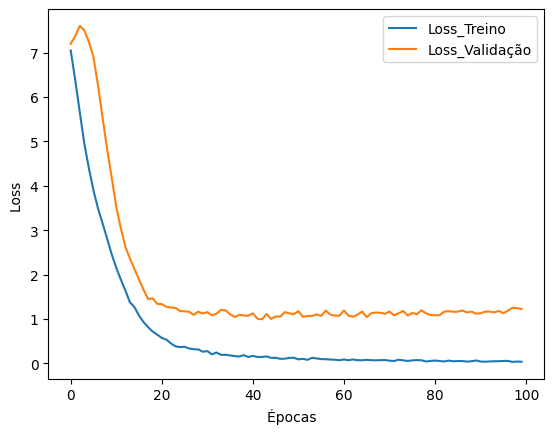

In [64]:
LOSS_train
LOSS_val 

plt.plot(epochs,LOSS_train,)
plt.plot(epochs,LOSS_val,)
plt.legend(["Loss_Treino","Loss_Validação"])
plt.xlabel('Épocas  ')
plt.ylabel('Loss ')
plt.show()

In [87]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [89]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

IndexError: ignored

In [81]:
print("predições = "f"{PREDICTED}")
print("labels = "f"{LABEL}")

CM_test = confusion_matrix(LABEL, PREDICTED)
print("Matriz de confução: \n"f"{CM_test}")

predições = ['saudável', 'pneumonia ', 'saudável', 'saudável', 'saudável', 'saudável', 'pneumonia ', 'pneumonia ', 'pneumonia ', 'saudável', 'saudável', 'saudável', 'saudável', 'saudável', 'saudável', 'pneumonia ', 'saudável', 'covid', 'saudável', 'saudável', 'saudável', 'pneumonia ', 'pneumonia ', 'saudável', 'saudável', 'saudável']
labels = ['saudável', 'pneumonia ', 'saudável', 'saudável', 'covid', 'pneumonia ', 'saudável', 'pneumonia ', 'pneumonia ', 'saudável', 'covid', 'covid', 'saudável', 'saudável', 'saudável', 'covid', 'saudável', 'covid', 'saudável', 'covid', 'saudável', 'pneumonia ', 'covid', 'saudável', 'saudável', 'saudável']
Matriz de confução: 
[[ 1  2  4]
 [ 0  4  1]
 [ 0  1 13]]
